In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zoneinfo import ZoneInfo

In [4]:
import preprocessing as preproc

## USGS Data Collection

In [63]:
int_freq = 60 # hourly interval

In [65]:
start_date = '2022-01-01'
end_date = '2024-12-31'
date_range = preproc.create_date_range(start_date, end_date)

In [67]:
inflow_site = '14128600'

## Collect Dataset #1
df1 = preproc.preprocess(inflow_site, int_freq, start_date, end_date)

COLUMBIA RIVER AT STEVENSON, WA
Removed 3 duplicate rows

Removed 0 rows with NaN in '00065'

Imputed 3 rows


In [77]:
outflow_site = '14105700'

## Collect Dataset #2
# Note: Can update this to retrieve discharge data as well
df2 = preproc.preprocess(outflow_site, int_freq, start_date, end_date)

COLUMBIA RIVER AT THE DALLES, OR
Removed 3 duplicate rows

Removed 116 rows with NaN in '00065'

Imputed 119 rows


In [227]:
df_merge = df1.copy()
df_merge.rename(columns={'00065': 'inflow_ft'}, inplace=True)
# df_merge = df_merge.merge(df2, left_index=True, right_index=True, how='inner')
# df_merge.rename(columns={'00065': 'up_outflow'}, inplace=True)
# df_merge.drop(['site_no_x', 'site_no_y'], axis=1, inplace=True)
df_merge.drop(['site_no'], axis=1, inplace=True)
df_merge = df_merge.reset_index()

## USACE Data Collection

In [230]:
bon_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/bonneville/"
tda_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/dalles/"

In [232]:
## Load Bonneville Data
# Manually fixing timezone + extra datapoint

bon_hourly = pd.read_csv(bon_path + "bon-hourlyops.csv")
bon_hourly['Date Time'] = pd.to_datetime(bon_hourly['Date Time'])
bon_hourly['Date Time'] = bon_hourly['Date Time'] + pd.Timedelta(hours=3)
bon_hourly = bon_hourly.iloc[1:].reset_index(drop=True)

In [234]:
len(bon_hourly)

26303

In [236]:
bon_hourly.columns

Index(['Date Time', 'BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]',
       'BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs]',
       'BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]',
       'BON.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]'],
      dtype='object')

In [238]:
bon = bon_hourly.copy()
bon = bon.rename(columns={"BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]": 'inflow_kcfs'})
bon = bon.rename(columns={'BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]': 'forebay_ft'})
bon = bon.rename(columns={"Date Time": 'datetime'})
bon = bon[['datetime', 'inflow_kcfs', 'forebay_ft']]

In [240]:
bon.dropna(inplace = True)

In [242]:
bon.head()

,datetime,inflow_kcfs,forebay_ft
1,2022-01-01 01:00:00,185.840,74.2
7,2022-01-01 07:00:00,189.168,74.1
13,2022-01-01 13:00:00,190.632,73.8
19,2022-01-01 19:00:00,191.640,73.9
25,2022-01-02 01:00:00,187.081,74.4


### Inflow Height Histograms

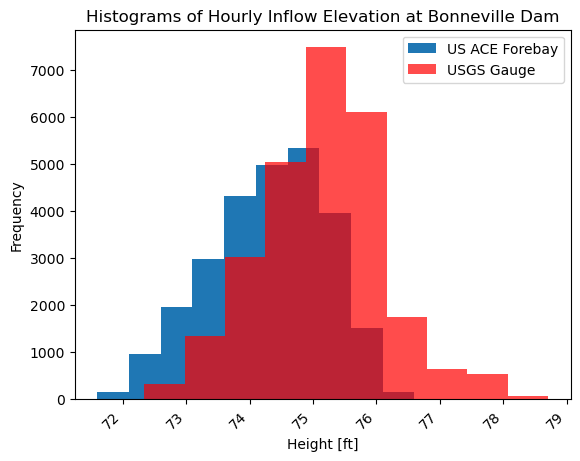

In [245]:
plt.hist(bon_hourly['BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]'], label = "US ACE Forebay")
plt.hist(df_merge.inflow_ft, alpha=.7, color="red", label = "USGS Gauge")
plt.title('Histograms of Hourly Inflow Elevation at Bonneville Dam')
plt.ylabel('Frequency')
plt.xlabel('Height [ft]')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

### Merge Datasets

In [248]:
df_merge = df_merge.merge(bon, on="datetime", how='inner')

In [250]:
df_merge.head()

,datetime,inflow_ft,inflow_kcfs,forebay_ft
0,2022-01-01 01:00:00,75.34,185.840,74.2
1,2022-01-01 07:00:00,74.82,189.168,74.1
2,2022-01-01 13:00:00,75.13,190.632,73.8
3,2022-01-01 19:00:00,75.11,191.640,73.9
4,2022-01-02 01:00:00,75.28,187.081,74.4


In [252]:
len(df_merge)

4383

In [254]:
df_merge.isna().sum()

datetime       0
inflow_ft      0
inflow_kcfs    0
forebay_ft     0
dtype: int64

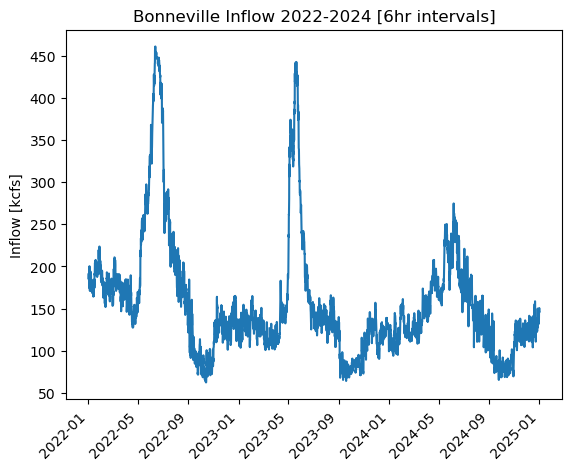

In [554]:
plt.plot(df_merge['datetime'], df_merge['inflow_kcfs'])
plt.title('Bonneville Inflow 2022-2024 [6hr intervals]')
plt.ylabel('Inflow [kcfs]')
plt.xticks(rotation=45, ha='right')
plt.show()

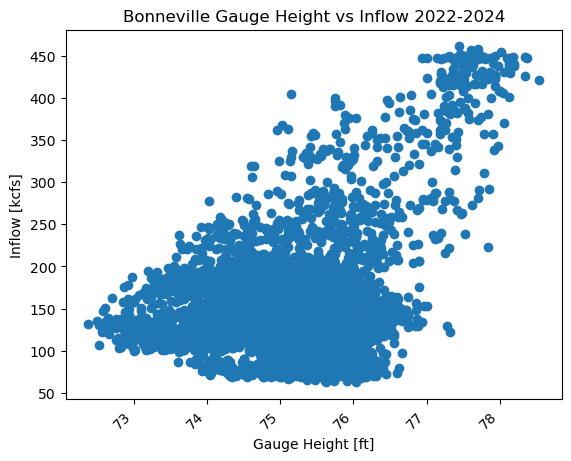

In [258]:
plt.scatter(df_merge.inflow_ft, df_merge.inflow_kcfs)
plt.title('Bonneville Gauge Height vs Inflow 2022-2024')
plt.ylabel('Inflow [kcfs]')
plt.xlabel('Gauge Height [ft]')
plt.xticks(rotation=45, ha='right')
plt.show()

In [207]:
i = int(np.floor(4384*(2/3)))

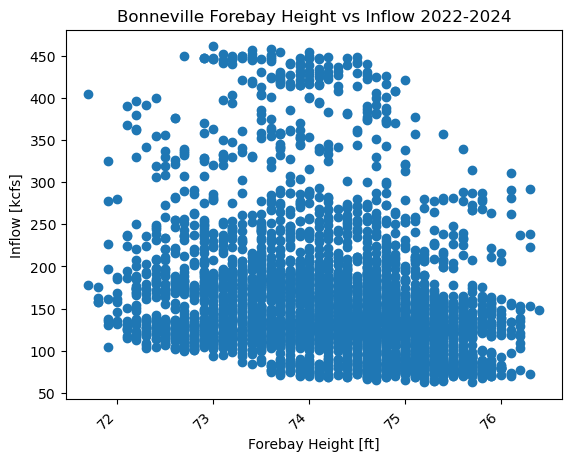

In [266]:
plt.scatter(df_merge.forebay_ft, df_merge.inflow_kcfs)
plt.title('Bonneville Forebay Height vs Inflow 2022-2024')
plt.ylabel('Inflow [kcfs]')
plt.xlabel('Forebay Height [ft]')
plt.xticks(rotation=45, ha='right')
plt.show()

## Correlation Analysis

### Autocorrelation Function (ACF)

The sample autocorrelation at lag \(k\):

$$
\rho_k \;=\;
\frac{\displaystyle \sum_{t=k+1}^{T}
        \left(y_t - \bar{y}\right)
        \left(y_{\,t-k} - \bar{y}\right)}
     {\displaystyle \sum_{t=1}^{T}
        \left(y_t - \bar{y}\right)^2}
$$


### Partial Autocorrelation Function (PACF)

Define \(\phi_{kk}\) as the coefficient on \(y_{t-k}\) when you regress
\(y_t\) on all intervening lags \(y_{t-1},\dots,y_{t-k}\):

$$
y_t \;=\;
\beta_1\,y_{t-1} \;+\;
\beta_2\,y_{t-2} \;+\;\dots+\;
\beta_k\,y_{t-k} \;+\;
\varepsilon_t.
$$

Then

$$
\phi_{kk} \;=\; \beta_k.
$$


In [328]:
h = df_merge[['inflow_ft']]
h.index = pd.to_datetime(df_merge.datetime)
q = df_merge.inflow_kcfs

In [363]:
h.head()

,inflow_ft
datetime,
2022-01-01 01:00:00,75.34
2022-01-01 07:00:00,74.82
2022-01-01 13:00:00,75.13
2022-01-01 19:00:00,75.11
2022-01-02 01:00:00,75.28


### Find the lag with the strongest (partial) autocorrelation
Try the ACF first; if you suspect higher-order structure, look at the PACF too.  
This helper returns the lag with the highest absolute value, skipping lag 0.

In [341]:
from statsmodels.tsa.stattools import acf, pacf

def strongest_lag(series, *, max_lag=96, method="acf"):
    if method == "acf":
        vals = acf(series, nlags=max_lag, fft=True, missing="drop")
    elif method == "pacf":
        vals = pacf(series, nlags=max_lag, method="ywm")
    else:
        raise ValueError("method must be 'acf' or 'pacf'")
    lag = 1 + np.argmax(np.abs(vals[1:]))  # +1 to offset lag-0
    return lag, vals[lag], vals

In [353]:
## Test acf

lag, rho, acf_vals = strongest_lag(h, max_lag=48, method="acf")
print(f"Strongest lag: {lag} steps  (ρ = {rho:.3f})")


Strongest lag: 1 steps  (ρ = 0.912)


In [355]:
## Test pacf

lag, rho, pacf_vals = strongest_lag(h, max_lag=48, method="pacf")
print(f"Strongest lag: {lag} steps  (ρ = {rho:.3f})")

Strongest lag: 1 steps  (ρ = 0.912)


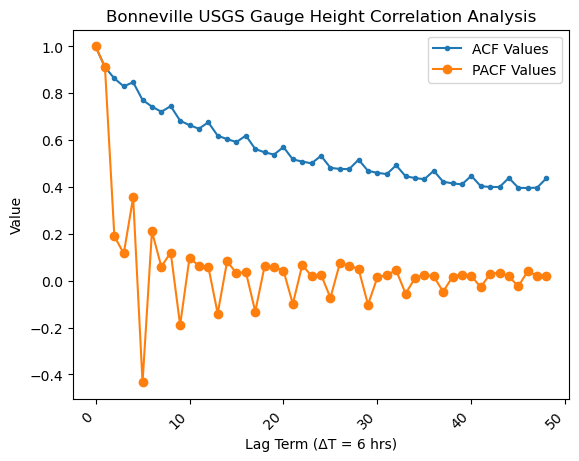

In [393]:
plt.plot(acf_vals, marker='o', markersize=3, label="ACF Values")
plt.plot(pacf_vals, marker='o', label = "PACF Values")
plt.title('Bonneville USGS Gauge Height Correlation Analysis')
plt.ylabel('Value')
plt.xlabel('Lag Term (ΔT = 6 hrs)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

### Estimate $\hat{\beta}$ at Lag $k$

Let  

* $y_t$  be the original series  
* $y_{t-k}$  its value shifted back $k$ steps  
* $\hat{\beta}$  the coefficient we want to estimate  

We fit the one-lag regression

$$
y_t \;=\; \hat{\beta}\,y_{t-k} + \varepsilon_t ,
$$

and the ordinary-least-squares estimate is

$$
\hat{\beta} \;=\;
\frac{\displaystyle \sum_{t = k+1}^{T} y_t\,y_{t-k}}
     {\displaystyle \sum_{t = k+1}^{T} y_{t-k}^{\,2}} .
$$

This $\hat{\beta}$ captures the strength of the dominant hysteresis (memory) term at lag $k$.


In [429]:
col = "inflow_ft"

# y = original series as a Series
y = h[col].rename("y")         # Series, not DataFrame

# x = lagged version, kept as a Series too
x = h[col].shift(lag).rename("x")

# Combine and drop the NAs that the shift introduces
data = pd.concat([x, y], axis=1).dropna()

# Ordinary-least-squares estimate of β̂ at that lag
beta = np.linalg.lstsq(data[["x"]], data["y"], rcond=None)[0][0]
print(f"lag {lag} → β̂ = {beta:.3f}")

lag 1 → β̂ = 1.000


### Remove the Dominant Hysteresis Term

Let:

- \( $y_t $\) be the original time series  
- \( $k$ \) be the dominant lag  
- \($ \hat{\beta}$ \) be the estimated AR coefficient at lag \( k \)

We compute the adjusted series \($ \tilde{y}_t $\) as:

\[
$\tilde{y}_t = y_t - \hat{\beta} \cdot y_{t-k}$
\]

This removes the contribution of the lag-\($k $\) memory term.



In [439]:
h_adj = y - beta * x

In [462]:
h_adj.head()

datetime
2022-01-01 01:00:00         NaN
2022-01-01 07:00:00   -0.518550
2022-01-01 13:00:00    0.311440
2022-01-01 19:00:00   -0.018554
2022-01-02 01:00:00    0.171446
dtype: float64

## Correlation for Whitened Gauge Height

### Validate the fix
* Plot the ACF/PACF again on h_adj – the spike at lag should shrink.

* Run Ljung-Box or portmanteau tests to confirm remaining serial correlation is insignificant at operational lags.

* Back-test forecasts: does error (MAPE, RMSE) drop relative to the original series?

### Common pitfalls & cures
| Symptom                         | Likely cause                | Quick check            | Remedy                                                                |                   |                             |
| ------------------------------- | --------------------------- | ---------------------- | --------------------------------------------------------------------- | ----------------- | --------------------------- |
| Lag spikes every 48 or 96 steps | Diurnal/weekend seasonality | Plot daily ACF heatmap | Seasonal differencing or add Fourier terms                            |                   |                             |
| Two comparable peaks            | Bimodal inflow behaviour    | Box-plots by month     | Model separate regimes or use a State-Space/Markov-switching approach |                   |                             |
| Coefficient                     | β̂                          | ≥ 1                    | Non-stationary (unit-root) process                                    | `adfuller()` test | First-difference the series |



Strongest lag: 4 steps  (ρ = 0.531)


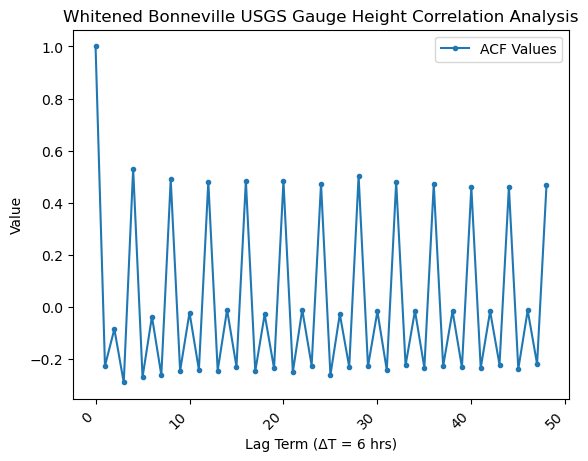

In [556]:
lag, rho, acf_vals = strongest_lag(h_adj, max_lag=48, method="acf")
print(f"Strongest lag: {lag} steps  (ρ = {rho:.3f})")

#lag, rho, pacf_vals = strongest_lag(h_adj, max_lag=48, method="pacf")
#print(f"Strongest lag: {lag} steps  (ρ = {rho:.3f})")

plt.plot(acf_vals, marker='o', markersize=3, label="ACF Values")
#plt.plot(pacf_vals, marker='o', label = "PACF Values")
plt.title('Whitened Bonneville USGS Gauge Height Correlation Analysis')
plt.ylabel('Value')
plt.xlabel('Lag Term (ΔT = 6 hrs)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

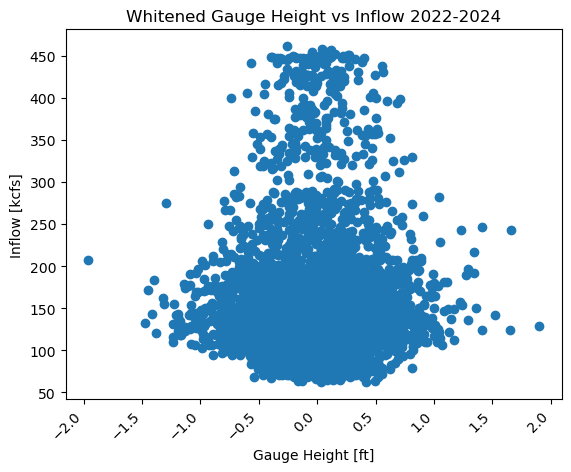

In [478]:
plt.scatter(h_adj, df_merge.inflow_kcfs)
plt.title('Whitened Gauge Height vs Inflow 2022-2024')
plt.ylabel('Inflow [kcfs]')
plt.xlabel('Gauge Height [ft]')
plt.xticks(rotation=45, ha='right')
plt.show()

$$ \tilde{y}_t = y_t -  y_{t-1}$$

$\hat{\beta} = 1$ means a coefficient of exactly (or very nearly) 1 at lag 1 almost always means the series behaves like a random walk / unit-root process, i.e.

$$ y_t = y_{t-1} + \epsilon_t$$

| Implication                               | Why it happens                                                      | Typical next step                                                                                              |
| ----------------------------------------- | ------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **Non-stationary**                        | Variance grows with time; ACF decays very slowly.                   | *Difference* the series: $\nabla y_t = y_t - y_{t-1}$.                                                         |
| **AR coefficient estimates max out at 1** | OLS can’t go above 1 because the best fit is “copy the last value.” | Run a unit-root test (e.g. Augmented Dickey–Fuller) to confirm; then model the *differences* with ARMA/GARCH/… |


<Axes: title={'center': 'First difference'}, xlabel='datetime'>

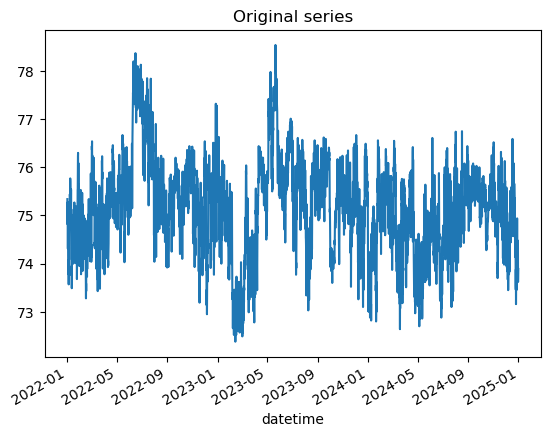

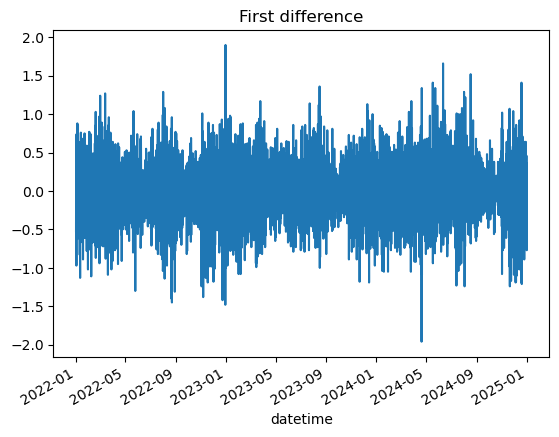

In [498]:
plt.figure()
h[col].plot(title="Original series")
plt.figure()
h[col].diff().dropna().plot(title="First difference")


**If the first-difference plot looks mean-reverting while the raw series drifts, you’ve confirmed the unit root**

🔍 What does mean-reverting look like?
A mean-reverting time series (Like the Difference Series!):

* Tends to return to a central level (mean or long-term average)

* Has fluctuations that “bounce around” a stable band

* Doesn’t drift away indefinitely over time

In contrast, a non-mean-reverting (unit root or random walk) series (Like the Original Series!):

* Wanders freely

* Can trend upward or downward for long stretches

* Has a variance that grows over time

In [525]:
from statsmodels.tsa.stattools import adfuller
adf_stat, p, *_ = adfuller(h[col].dropna(), autolag="AIC")
print(f"ADF statistic = {adf_stat:.2f},  p-value = {p:.3f}")

ADF statistic = -5.09,  p-value = 0.000


* p < 0.05 → reject unit root → β̂ should drop below 1 if you re-estimate.

* p ≥ 0.05 → cannot reject unit root → difference the series.

In [505]:
# Re-estimate β̂ on the differenced series:
h_diff = h[col].diff().dropna()
lag = 1

In [517]:
x = h_diff.shift(lag).rename("x")
y = h_diff.rename("y")
data = pd.concat([x, y], axis=1).dropna()

beta = np.linalg.lstsq(data[["x"]], data["y"], rcond=None)[0][0]
print(f"β̂ on first difference = {beta:.3f}")


β̂ on first difference = -0.226


We define the adjusted series
$$
\tilde{y}_t \;=\; y_t \;-\; \hat{\beta}\,y_{t-k}.
$$

$$
\tilde{\tilde{y}_t} \;=\; \tilde{y_t} \;+\; 0.226\,\tilde{y}_{t-1}.
$$

In [528]:
h_diff_adj = y - beta * x
h_diff_adj.name = f"{col}_adj"

In [538]:
len(h_diff_adj)

4382

In [540]:
len(df_merge.inflow_kcfs)

4383

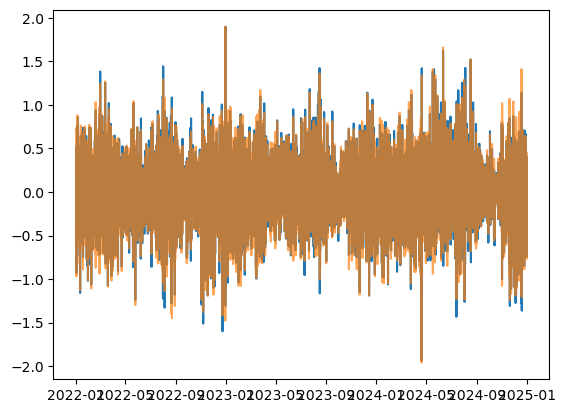

In [552]:
plt.plot(h_diff_adj)
plt.plot(h_adj, alpha = 0.7)

## LASSO Regression for Streamflow Rating

In [559]:
train_start_year = '2022'
test_start_year = '2024'

In [565]:
col

'inflow_ft'

In [581]:
df_reg = df_merge.copy()

In [585]:
def create_lags(df_reg, col, p):

    # Adding downstream lag features to the DataFrame
    for i in range(1, p):  # Creating lag features up to p time units
        df_reg[f'Y_Lag_{i}'] = df_reg[col].shift(i)

    # Drop rows with NaN values resulting from creating lag features
    df_reg.dropna(inplace=True)
    df_reg = df_reg.rename(columns={1: '1'})

    feature_cols = [col] + [f'Y_Lag_{lag}' for lag in range(1, p)]
    
    return df_reg, feature_cols

In [573]:
## Create lag features

p = 7 

df_reg, feature_cols = create_lags(df_reg, col, p)

In [595]:
feature_cols.append(col)

In [583]:
df_reg.head()

,datetime,inflow_ft,inflow_kcfs,forebay_ft,Y_Lag_1,Y_Lag_2,Y_Lag_3,Y_Lag_4,Y_Lag_5,Y_Lag_6
6,2022-01-02 13:00:00,75.05,182.172,73.9,74.31,75.28,75.11,75.13,74.82,75.34
7,2022-01-02 19:00:00,75.02,197.233,74.1,75.05,74.31,75.28,75.11,75.13,74.82
8,2022-01-03 01:00:00,75.21,191.037,74.3,75.02,75.05,74.31,75.28,75.11,75.13
9,2022-01-03 07:00:00,74.70,198.613,74.1,75.21,75.02,75.05,74.31,75.28,75.11
10,2022-01-03 13:00:00,74.18,200.235,73.3,74.70,75.21,75.02,75.05,74.31,75.28


In [599]:
## Split the data into training and testing sets

train_data = df_reg[(df_reg.datetime < test_start_year)]
test_data = df_reg[(df_reg.datetime >= test_start_year)]

X_train = train_data[feature_cols]
y_train = train_data['inflow_kcfs']

X_test = test_data[feature_cols]
y_test = test_data['inflow_kcfs']

In [603]:
X_train.head()

,Y_Lag_1,Y_Lag_2,Y_Lag_3,Y_Lag_4,Y_Lag_5,Y_Lag_6,inflow_ft
6,74.31,75.28,75.11,75.13,74.82,75.34,75.05
7,75.05,74.31,75.28,75.11,75.13,74.82,75.02
8,75.02,75.05,74.31,75.28,75.11,75.13,75.21
9,75.21,75.02,75.05,74.31,75.28,75.11,74.70
10,74.70,75.21,75.02,75.05,74.31,75.28,74.18


In [605]:
lasso_train = X_train.copy() 
lasso_test = X_test.copy()

In [607]:
## Cross-Validation for Hyperparameter Finetuning

lasso_cv = LassoCV(cv=5, positive=True).fit(lasso_train, y_train)
alpha_star = lasso_cv.alpha_
print("Best alpha:", alpha_star)

Best alpha: 0.04392950329711304


In [609]:
## Create and fit LASSO model

#lasso = Lasso(alpha=0, positive=True)  # alpha is the regularization strength (higher = more shrinkage)
lasso = Lasso(alpha=alpha_star, positive=True)
lasso.fit(lasso_train, y_train)

Lasso(alpha=0.04392950329711304, positive=True)

In [611]:
## Make predictions

y_pred = pd.Series(lasso.predict(lasso_test))

In [613]:
## View coefficients

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lasso.coef_
})

# Optional: Sort by magnitude or filter out zeros
coef_df = coef_df[coef_df['coefficient'] != 0]  # remove zeroed-out features
coef_df = coef_df.sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df)

     feature  coefficient
6  inflow_ft    17.532006
5    Y_Lag_6    12.190507
0    Y_Lag_1     6.805059
2    Y_Lag_3     5.729247
4    Y_Lag_5     4.595878


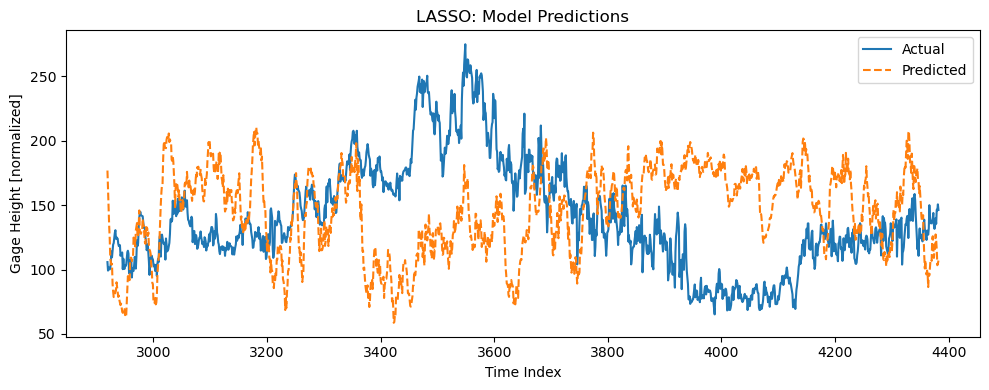

In [615]:
preproc.plot_forecasts("LASSO", y_test, y_pred)

In [617]:
preproc.print_test_stats(y_test, y_pred)

RMSE: 61.060
MAE: 50.931
R²: -1.160
